<a href="https://colab.research.google.com/github/TopoVague/IBC_dev/blob/main/MSD_to_Apartment_Layouts_EP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apartment-Level Floor Plan Dataset Derived From MSD

In this notebook, we look into the Modified Swiss Dwelling (MSD)  which is a dataset of apartment-level floor plans  that are information-rich and easy-to-work with
The notebook contains the following sections:

**(1) Apartment-level graph extraction.**
From the table (.csv) associated with the MSD floor plan dataset, we extract all distinct apartments that can be found in there (i.e., we develop a function that filters all the building elements corresponding to a particular apartment ID).
Each apartment (i.e., list of building elements) is subsequently converted into a richly-attributed graph, where nodes represent rooms and edges their relations.
**Node attributes** include the room's geometry and function.
**Edge attributes** include the type of connectivity and the associated geometry (e.g., geometry of the door) if such a geometry exists in the first place.
**Graph-level** attributes include the floor ID, apartment ID, and the sets of walls and windows (as geometries) that 'built' the apartment.
We have developed some sophisticated plotting functions in which it is remarkably easy to include your own coloring scheme, and which type of elements you want to be visualized (e.g., whether you want to see back walls, windows, doors, or entrances).

**(2) Filtering.**
In here we remove apartments that are too small or too large ($5 \leq N \leq 12 $, $N$ is the number of rooms), that are not connected (i.e., there exist two, or more, subgraphs that do not share any edge between their corresponding sets of nodes).


**(3) Meta-data analysis.**
In this section, we provide some meta-data about the apartment-level floor plan dataset.
These meta-data regards mostly distributions, such as the distribution of the number of rooms (numeric).



## (1) Apartment-level graph extraction

This part explains how to extract the apartment-level graphs from the corresponding dataframe of MSD and, subsequently, how to nicely visualize the layouts and corresponding connectivity from these graphs.

The graph extraction algorithm in this notebook is slightly different from the one in our Github ($\longrightarrow$ [Data Curation Part 2 - Graph Extraction](https://github.com/caspervanengelenburg/msd/blob/main/NB%20-%20Data%20Curation%202%20-%20Graph%20Extraction.ipynb)):
We include more features / attributes to the nodes, edges, and the graph itself (1) and the room categorizations are slightly different (2).
The format of the data stays the same; so, if you already worked with the other graph data, it won't be difficult to modify the code to work with the ones we'll extract here.

### Loading dataframe

Here we load the MSD dataset, which is already cleaned and filtered on residential-ony floor plans. For details, see:

- Reference paper $\longrightarrow$ [MSD: A Benchmark Dataset for Floor Plan Generation of Building Complexes
](https://arxiv.org/abs/2407.10121)
- reference GitHub $\longrightarrow$ [Data Curation Part 1 - Cleaning and Filtering](https://github.com/caspervanengelenburg/msd/blob/main/NB%20-%20Data%20Curation%201%20-%20Cleaning%20and%20Filtering.ipynb)

In our case, the CSV that corresponds to the dataset is saved in in our Drive; hence, we mount our Drive first:

In [2]:
from google.colab import drive

# Mounts drive
drive.mount('/content/drive')

Mounted at /content/drive


Next, we load the CSV as a `geopandas` dataframe:

In [3]:
import pandas as pd
import os
from geopandas import GeoDataFrame as gdf

#print(os.getcwd())  # Prints the current working directory

file_path = r"/content/drive/My Drive/MSD_V2/mds_V2_5.372k.csv"# ! change to your directory
# Imports dataframe
print(file_path)
if os.path.exists(file_path):
    print("File exists, proceeding with read...")
    DF = gdf(pd.read_csv(file_path))
else:
    print("File not found!")

# Checks dataset size
print(f'Number of floors: {DF.floor_id.nunique()}')

/content/drive/My Drive/MSD_V2/mds_V2_5.372k.csv
File exists, proceeding with read...
Number of floors: 5372


To get an idea of the information within the dataframe, let's show the top (`.head`) of it.
Note that many of the columns from the *Swiss Dwellings* dataset ($\longrightarrow$ [Swiss Dwellings](https://zenodo.org/records/7788422)) are removed, to reduce clutter.

In [ ]:
DF.head(40)  # By default, head shows 5. Let's do a bit more, say 10.

,Unnamed: 0.1,Unnamed: 0,apartment_id,site_id,building_id,plan_id,floor_id,unit_id,area_id,unit_usage,entity_type,entity_subtype,geom,elevation,height,zoning,roomtype
0,0,0,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619311.0,RESIDENTIAL,area,BATHROOM,POLYGON ((-2.7337844078265210 4.07980744083215...,0.0,2.6,Zone3,Bathroom
1,1,1,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619303.0,RESIDENTIAL,area,LIVING_ROOM,POLYGON ((5.8278988701887320 7.816876723402971...,0.0,2.6,Zone2,Livingroom
2,2,2,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619322.0,RESIDENTIAL,area,ROOM,POLYGON ((6.7557107205191187 2.413369594812586...,0.0,2.6,Zone1,Bedroom
3,3,3,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619310.0,RESIDENTIAL,area,KITCHEN,POLYGON ((3.5821200013910017 5.140461688341117...,0.0,2.6,Zone2,Kitchen
4,4,4,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619312.0,RESIDENTIAL,area,ROOM,POLYGON ((3.0141380455489282 4.182056855151666...,0.0,2.6,Zone1,Bedroom
5,5,5,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619314.0,RESIDENTIAL,area,BALCONY,POLYGON ((6.6332818443542809 1.893154628642479...,0.0,2.6,Zone4,Balcony
6,6,6,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619315.0,RESIDENTIAL,area,CORRIDOR,POLYGON ((-0.8407103586364295 2.49132970436546...,0.0,2.6,Zone2,Corridor
7,7,7,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,NaN,RESIDENTIAL,separator,WALL,POLYGON ((10.1119554317056775 4.97986505334461...,0.0,2.6,Structure,Structure
8,8,8,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,NaN,RESIDENTIAL,separator,WALL,POLYGON ((-1.1111620360693770 4.87501963298749...,0.0,2.6,Structure,Structure
9,9,9,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,NaN,RESIDENTIAL,separator,WALL,POLYGON ((3.9249330187591767 -1.31971700237801...,0.0,2.6,Structure,Structure


Each element in the dataframe is an architectural element, and has a corresponding geometry (`geom`), which is a represented by polygon.
Each element is located in:

- a particular site (accessed by the column `site_id`);
- a building (`building_id`);
- a floor (`floor_id)`; and
- an apartment (`apartment_id')`.

(We leave `plan_id`, `unit_id`, and `area_id` for what they are now. I.e.: we do not need them here.)

Before we extract the geometries, let's get an idea of the separator, opening, and room types:

In [4]:
# List types of separators
print("The following types of separators exist in the dataset:")
print(list(DF[DF.entity_type == 'separator'].entity_subtype.unique()))

# List types of openings
print("The following types of openings exist in the dataset:")
print(list(DF[DF.entity_type == 'opening'].entity_subtype.unique()))

# List types of circulation
print("The following type possible represents circulation cores:")
print(list(DF[DF.roomtype == 'Stairs'].roomtype.unique()))
print(list(DF[DF.roomtype == 'Corridor'].roomtype.unique()))
print(list(DF[DF.roomtype == 'Elevator'].roomtype.unique()))

# Show room types
print("The following types of spaces exist in the dataset:")
print(list(DF.roomtype.unique()))

# Show Zoning
print("The following types of zoning exist in the dataset:")
print(list(DF.zoning.unique()))

The following types of separators exist in the dataset:
['WALL', 'COLUMN']
The following types of openings exist in the dataset:
['DOOR', 'WINDOW', 'ENTRANCE_DOOR']
The following type possible represents circulation cores:
['Stairs']
['Corridor']
[]
The following types of spaces exist in the dataset:
['Bathroom', 'Livingroom', 'Bedroom', 'Kitchen', 'Balcony', 'Corridor', 'Structure', 'Door', 'Window', 'Entrance Door', 'Dining', 'Stairs', 'Storeroom']
The following types of zoning exist in the dataset:
['Zone3', 'Zone2', 'Zone1', 'Zone4', 'Structure', 'Door', 'Window', 'Entrance Door']


Note that we will only need the `roomtype` column for all the information that we want as doors, entrance doors, and windows are already included as distinct categories already.

### Extracting geometries

Let's get the geometries associated with the walls and columns (1), doors (2), entrance doors (3), and windows (4).
We will do so for one floor (randomly sampled from the list of floor IDs in `floor_id`)


# Floorplan Analysis

In [5]:
from shapely import wkt


def get_geometries_from_id(df, building_id, floor_id, apartment_id=None, column='roomtype'):
    """Function that extracts all geometries and associated categories from a
    particular floor and apartment ID. Outputs a list of geometries (1),
    a corresponding list of categories (2) and a list of zoning (3)"""

    # Samples dataframe based on floor and, if asked for, apartment ID
    df_floor = df[df.floor_id == floor_id].reset_index(drop=True)
    if apartment_id is not None:
        df_floor = df_floor[df_floor.apartment_id == apartment_id].reset_index(drop=True)
    else:
        pass

    # Check if df_floor is empty before proceeding
    if df_floor.empty:
        print(f"Warning: No data found for floor_id={floor_id}, apartment_id={apartment_id}, column={column}")
        return [], [], []  # Return empty lists if no data is found

    df_floor.geom = df_floor.geom.apply(wkt.loads)

    # Get geometries and associated categories out
    geoms, cats, zonings = zip(*df_floor[["geom", column,"zoning"]].values)

    return geoms, cats, zonings

Select a building to Analyze

In [6]:
# Change this to select a different building
#passed Test  1 ,30, 50 ,100,500
selectedbuildingNumber = 50
selectedFloor = 0

# Gets list of building IDs and samples one (at 0)
building_ids = list(DF.building_id.dropna().unique())
#Get the building
building_id = building_ids[selectedbuildingNumber]

# Gets list of floor IDs for the specific building
floor_ids = list(DF[DF.building_id == building_id].floor_id.dropna().unique())

# Change the number to grab a different floor from the selected building
floor_id = floor_ids[selectedFloor]  # You can change this index to get a different floor

# Gets list of apartment IDs within the given floor of the selected building
apartment_ids = list(DF[(DF.building_id == building_id) & (DF.floor_id == floor_id)].apartment_id.dropna().unique())

# Gets geometries and associated categories for the selected building and floor
geoms, cats, zonings = get_geometries_from_id(DF, building_id, floor_id)


# Identifying spaces, walls, doors, etc., as before
spaces = [geom for geom, type in zip(geoms, cats) if type in ['Bathroom', 'Livingroom', 'Bedroom', 'Kitchen', 'Balcony', 'Corridor', 'Dining', 'Storeroom']]  # (1) spaces
walls = [geom for geom, type in zip(geoms, cats) if type == 'Structure']  # (1) Walls and columns
doors = [geom for geom, type in zip(geoms, cats) if type == 'Door']  # (2) Doors
entrances = [geom for geom, type in zip(geoms, cats) if type == 'Entrance Door']  # (3) Entrance doors
windows = [geom for geom, type in zip(geoms, cats) if type == 'Window']  # (4) Windows
cores = [geom for geom, type in zip(geoms, cats) if type == 'Stairs']  # (5) Circulation cores
shafts = [geom for geom, type in zip(geoms, cats) if type == 'Shaft']  # (6) Shafts

# Count distinct zones (excluding "Structure" if desired)
distinct_zones = set(z for z in zonings if z != 'Structure')




### Plot floorplan and identify circulation cores
Let's try to identify the circulation cores (NEED TO BE TESTED):
Let's plot the elements in one figure:


In [7]:
#REVISED version here -ha s been tested but needs further testing
from shapely.geometry import Polygon

def plot_polygon(ax, poly, label=None, **kwargs):
    """Plots a polygon by filling it up. Edges of shapes are avoided to show exactly the area that
    the elements occupy."""
    x, y = poly.exterior.xy
    ax.fill(x, y, label=label, **kwargs)
    return

def remove_duplicate_geometries(geoms):
    unique = []
    for g in geoms:
        if not any(g.equals(u) for u in unique):
            unique.append(g)
    return unique


def draw_walls_and_openings(ax, geoms, cats, zonings, apartment_ids, colors, debug=False):


    """Draws elements of the floor and identifies circulation corridors based on entrance vs. door contact."""
    # Classify geometry by category
    walls      = [g for g, c in zip(geoms, cats) if c == 'Structure']
    doors = remove_duplicate_geometries([g for g, c in zip(geoms, cats) if c == 'Door'])
    entrances = remove_duplicate_geometries([g for g, c in zip(geoms, cats) if c == 'Entrance Door'])
    #doors      = [g for g, c in zip(geoms, cats) if c == 'Door']
    #entrances  = [g for g, c in zip(geoms, cats) if c == 'Entrance Door']
    windows    = [g for g, c in zip(geoms, cats) if c == 'Window']
    intSpaces  = [g for g, c in zip(geoms, cats) if c in ['Bathroom', 'Livingroom', 'Bedroom', 'Kitchen', 'Balcony', 'Corridor', 'Dining', 'Storeroom']]
    extSpaces  = [g for g, c in zip(geoms, cats) if c == 'Balcony']
    cores      = [g for g, c in zip(geoms, cats) if c == 'Stairs']
    corridors  = [g for g, c in zip(geoms, cats) if c == 'Corridor']
    corridor_zones = [zone for geom, cat, zone in zip(geoms, cats, zonings) if cat == 'Corridor']


    # Identify core corridors
    buffer_size = 0.001  # You may tune this if needed
    core_corridors = []



    for i, (corridor, zone) in enumerate(zip(corridors, corridor_zones)):
        # add some buffer to make sure shapes interset
        buffered_corridor = corridor.buffer(buffer_size)

        entrance_count = 0
        door_count = 0

        # Count entrances intersecting corridor
        for entrance in entrances:
            if corridor.touches(entrance) or corridor.intersects(entrance):
                entrance_count += 1

       # Count doors intersecting corridor
        for door in doors:
            if buffered_corridor.intersects(door) or buffered_corridor.touches(door):
                door_count += 1
          #check if corridors intersect  with doors and entrances
        # Logic to identify circulation corridors
        core_corridor_condition1 = (zone == "Zone3") and (entrance_count > door_count)
        core_corridor_condition2 = (zone == "Zone2") and (entrance_count > door_count)
        core_corridor_condition3 = (door_count != 0) or (door_count != 1)

        # add logic if stairs intersects with corridor or touches
        if core_corridor_condition1 :
          core_corridors.append(corridor)
          print (f"Found circulation corridor [Corridor {i}] in the first case")
        elif core_corridor_condition2 and core_corridor_condition3 :
          core_corridors.append(corridor)
          print (f"Found circulation corridor [Corridor {i}]   in the second case")
        elif core_corridor_condition2 :
          core_corridors.append(corridor)
          print (f"Found circulation corridor [Corridor {i}]   in the third case")
        #print(f"[Corridor {i}] Entrances: {entrance_count}, Doors: {door_count},Zone: {zone}")




    #debugging
    if (debug == True):
      #print (corridor_zones)
      print(f"\nTotal corridors: {len(corridors)}")
      print(f"Core corridors:  {len(core_corridors)}\n")
      print(f"Stairs&Elevators:  {len(cores)}\n")
      print(f"Entrances:  {len(entrances)}\n")
      print(f"Doors:  {len(doors)}\n")
      #print(entrances)


    # Print details for the selected building and floor
    print(f"Building ID is  :\t\t\t{building_id} \n"
      f"Floor ID is    :\t\t\t{floor_id} \n"
      f"Number of floors:\t{len(floor_ids)}\n"
      f"Number of apartments:\t\t\t{len(apartment_ids)}\n"
      f"Number of spaces:\t{len(spaces)}\n"
      f"Number of ciculation spaces (staris, elevators etc):\t{len(cores)}\n"
      f"Number of Shafts:\t{len(shafts)}\n"
      f"Number of structural elements:\t{len(walls)}\n"
      f"Number of doors:\t\t\t\t{len(doors)}\n"
      f"Number of entrances:\t\t\t{len(entrances)}\n"
      f"Number of windows:\t\t\t{len(windows)}\n"
      f"Number of zones:\t\t\t\t{len(distinct_zones)}")

    # Plot
    _ = [plot_polygon(ax, g, facecolor=colors[0]) for g in walls]
    _ = [plot_polygon(ax, g, facecolor=colors[1]) for g in doors]
    _ = [plot_polygon(ax, g, facecolor=colors[2]) for g in entrances]
    _ = [plot_polygon(ax, g, facecolor=colors[3]) for g in windows]
    _ = [plot_polygon(ax, g, facecolor=colors[4]) for g in intSpaces]
    _ = [plot_polygon(ax, g, facecolor=colors[5]) for g in extSpaces]
    _ = [plot_polygon(ax, g, facecolor=colors[8]) for g in cores]
    _ = [plot_polygon(ax, g, facecolor=colors[6]) for g in corridors]
    _ = [plot_polygon(ax, g, facecolor=colors[7]) for g in core_corridors]


    return core_corridors, corridors, cores, doors

#test call
#fig, ax = plt.subplots(figsize=(10, 10))
#core_corridors, _, _, _ = draw_walls_and_openings(ax, geoms, cats, zonings, apartment_ids, colors)


Building ID is  :			15966 
Floor ID is    :			41333 
Number of floors:	2
Number of apartments:			2
Number of spaces:	14
Number of ciculation spaces (staris, elevators etc):	2
Number of Shafts:	0
Number of structural elements:	56
Number of doors:				13
Number of entrances:			3
Number of windows:			7
Number of zones:				7


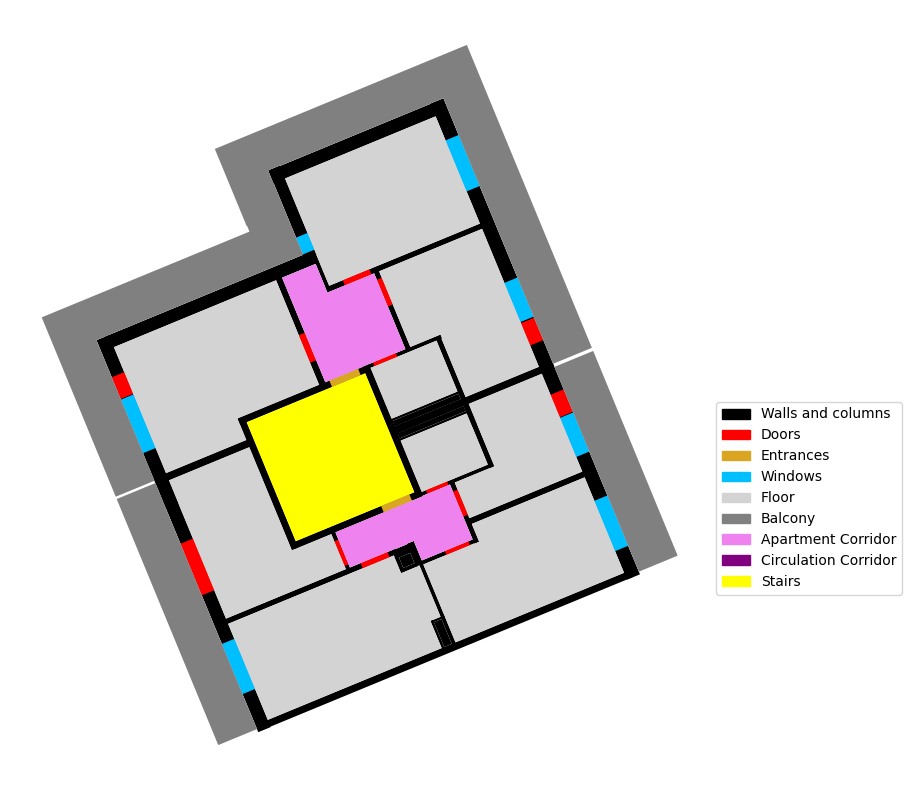

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Suggested colors for each geometry type
colors = [
    '#000000',  # 0 - Walls (Structure)
    '#FF0000',  # 1 - Doors
    "goldenrod",  # 2 - Entrance Doors
    "deepskyblue",  # 3 - Windows
    "Lightgrey",  # 4 - Internal spaces (Bathroom, Bedroom, etc.)
    "grey",  # 5 - External spaces (e.g., Balcony)
    "violet",  # 6 - Corridors (all)
    "purple",  # 7 - Core corridors (filtered)
    "yellow",  # 8 - Stairs (Cores)
]

#  Naming for legend
sep_names = [
    "Walls and columns", #0
    "Doors", #1
    "Entrances", #2
    "Windows", #3
    "Floor", #4
    "Balcony", #5
    "Apartment Corridor",#6
    "Circulation Corridor", #7
    "Stairs",#8

    ]

# Set figure and specs
fs = 10
fig, ax = plt.subplots(1, 1, figsize=(fs, fs))
ax.set_aspect('equal')
ax.axis('off')


# Plot geometries
#draw_walls_and_openings(ax, geoms, cats, zonings, sep_colors)
core_corridors, _, _, _ = draw_walls_and_openings(ax, geoms, cats, zonings, apartment_ids, colors)

# Create legend (left middle outside)
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, sep_names)]
_ = plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1, 0.5), fontsize=fs)

In [ ]:
#old version has issues with identifiying the core porperly
'''
def plot_polygon(ax, poly, label=None, **kwargs):
    """Plots a polygon by filling it up. Edges of shapes are avoided to show exactly the area that
    the elements occupy."""
    x, y = poly.exterior.xy
    ax.fill(x, y, label=label, **kwargs)
    return


#definition to draw the walls
def draw_walls_and_openings(ax, geoms, cats, zonings, colors, **kwargs):
    """Draws the walls and openings of a floor layout."""

    # Extracts walls and columns (1), doors (2), entrances (3), and windows (4)

    walls = [geom for geom, type in zip(geoms, cats) if type == 'Structure']  # (1) Walls and columns
    doors = [geom for geom, type in zip(geoms, cats) if type == 'Door']  # (2) Doors
    entrances = [geom for geom, type in zip(geoms, cats) if type == 'Entrance Door']  # (3) Entrance doors
    windows = [geom for geom, type in zip(geoms, cats) if type == 'Window']  # (4) Windows
    intSpaces = [geom for geom, type in zip(geoms, cats) if type == 'Bathroom' or 'Livingroom'or 'Bedroom'or 'Kitchen'or 'Balcony'or 'Corridor' or  'Dining' or 'Storeroom']  # (t) intSpaces
    extSpaces = [geom for geom, type in zip(geoms, cats) if type == 'Balcony']  # (6) exterior spaces
    cores = [geom for geom, type in zip(geoms, cats) if type == 'Stairs']  # (7) Cores
    corridors = [geom for geom, cat, zone in zip(geoms, cats, zonings) if cat == 'Corridor'] # (8) Corridors
    #corridors = [geom for geom, cat, zone in zip(geoms, cats, zonings) if cat == 'Corridor' and zone == 'Zone2'] # (8) Corridors

    # Get the number of apartments in the current floor
    num_apartments = len(apartment_ids)
    #define a variable for the circulation corridros
    core_corridors = []
    corridor_count = 0

    circulationCores  = 0
    stairFlag = False
    counter = 0


    # Helper function to check if a corridor is adjacent to stairs within a threshold
    def is_adjacent_to_stairs(corridors, stairs):
        for corridor in corridors:
          for door in doors:
            for stair in stairs:
              print("distance corridor to stair",corridor.distance(stair))
              print("stair to door",door.distance(stair))
              if door.distance(stair) <= 5:
                  print("got here")
                  return True
        return False

    for corridor in corridors:
        adj_door_count = 0
        adj_entrance_count = 0
        for entrance in entrances:
          for door in doors:
            if (corridor.touches(door) or corridor.intersects(door)):
                adj_door_count = adj_door_count + 1
            elif (corridor.touches(entrance) or corridor.intersects(entrance)):
                adj_entrance_count = adj_entrance_count + 1
            else:
                continue
        print("corridor touching doors:", adj_door_count)
        print("corridor touching entrances", adj_entrance_count)
        if (adj_entrance_count<adj_door_count):
          print ("yooo. corridor index", counter)
        counter +=1


    for corridor in corridors:
      for stair in cores:
        for door in doors:
          if stair.intersects(door) or stair.touches(door):
            stairFlag = True
            print ("stairs is a separate room/", stairFlag)
      counter += 1
    # Corridor-Door-Stair connectivity check 5
    index = 0
    for corridor in corridors:
        for entrance in entrances:
            if corridor.intersects(entrance) or corridor.touches(entrance):  # entrance door must touch corridor
                for stair in cores:
                    if stair.intersects(entrance) or stair.touches(entrance) or stair.touches(corridor):  # and also touch a stair
                        print("got in check point 1-adding a circulation corridor ")
                        print (stairFlag)
                        if corridor_count < num_apartments:
                          print("got in check point 2-adding a circulation corridor ")
                          core_corridors.append(corridor)
                          corridor_count = corridor_count+1
                          #break  # one match is enough
                    elif (stairFlag == True):
                        core_corridors.append(corridor)
                        circulationCores += 1
                        print("got in check point 3-ADDED a circulation corridor ")
                        #break

                    else:
                      print("got in check point 4-not adding a circulation corridor ")
                      continue

                break


    print(f"Counting corridors in the floor:\t\t\t{corridor_count}\n")
    print(f"Number of  corridors in the floor:\t\t\t{len(corridors)}\n"
          f"Number of circulation corridors:\t\t\t{len(core_corridors)}\n")
    # Corridor-Door-Stair connectivity check 2 Revised
    #for corridor in corridors:
    #    for stair in cores:
    #      if stair.touches(corridor):  # stair must touch a corridor
    #        core_corridors.append(corridor)
    #        break  # one match is enough
    #      else:
    #        continue
    #      break
      # Corridor-Door-Stair connectivity check 4
    #for corridor in corridors:
        # Check adjacency to stairs
    #    if is_adjacent_to_stairs(corridor, cores):
    #        # Count entrances touching the corridor
    #        entrance_count = sum(1 for door in doors if corridor.intersects(door))  # Change `intersects` if needed
    #        if entrance_count >= num_apartments:
    #            core_corridors.append(corridor)

  # Corridor-Door-Stair connectivity check 3
 #   for corridor in corridors:
 #       # Check if the corridor is adjacent to any stair (core)
 #       if any(corridor.intersects(stair) for stair in cores):
 #           # Check if the number of doors/entrances touching the corridor matches the number of apartments
 #           if sum(1 for entrance in entrances if corridor.intersects(entrance) or corridor.touches(entrance)) >= num_apartments:
 #               core_corridors.append(corridor)


    # Plot geometries
    # Draws walls first; doors and windows 'overwrite' the walls. (Makes more sense.)

    #_ = [plot_polygon(ax, geom, facecolor=colors[0]) for geom in spaces]
    _ = [plot_polygon(ax, geom, facecolor=colors[4]) for geom in intSpaces]
    _ = [plot_polygon(ax, geom, facecolor=colors[5]) for geom in extSpaces]
    _ = [plot_polygon(ax, geom, facecolor=colors[6]) for geom in corridors]
    _ = [plot_polygon(ax, geom, facecolor=colors[7]) for geom in core_corridors]
    _ = [plot_polygon(ax, geom, facecolor=colors[8]) for geom in cores]

    _ = [plot_polygon(ax, geom, facecolor=colors[0]) for geom in walls]
    _ = [plot_polygon(ax, geom, facecolor=colors[1]) for geom in doors]
    _ = [plot_polygon(ax, geom, facecolor=colors[2]) for geom in entrances]
    _ = [plot_polygon(ax, geom, facecolor=colors[3]) for geom in windows]

'''

'\ndef plot_polygon(ax, poly, label=None, **kwargs):\n    """Plots a polygon by filling it up. Edges of shapes are avoided to show exactly the area that\n    the elements occupy."""\n    x, y = poly.exterior.xy\n    ax.fill(x, y, label=label, **kwargs)\n    return\n\n\n#definition to draw the walls\ndef draw_walls_and_openings(ax, geoms, cats, zonings, colors, **kwargs):\n    """Draws the walls and openings of a floor layout."""\n\n    # Extracts walls and columns (1), doors (2), entrances (3), and windows (4)\n\n    walls = [geom for geom, type in zip(geoms, cats) if type == \'Structure\']  # (1) Walls and columns\n    doors = [geom for geom, type in zip(geoms, cats) if type == \'Door\']  # (2) Doors\n    entrances = [geom for geom, type in zip(geoms, cats) if type == \'Entrance Door\']  # (3) Entrance doors\n    windows = [geom for geom, type in zip(geoms, cats) if type == \'Window\']  # (4) Windows\n    intSpaces = [geom for geom, type in zip(geoms, cats) if type == \'Bathroom\' or 

Now let's plot the same floorplan showing/color coded based on the zoning feature
TO DO COLOR BY APARTMENT

In [9]:
from shapely.geometry import Polygon
import plotly.graph_objects as go
import random

def plot_interactive_floorplan(geoms, cats, zonings, **kwargs):
    """Plot geometries interactively with Plotly and show zone info on hover."""

    # Color map for zones
    zone_colors = {
        "Zone1": "lightblue",
        "Zone2": "lightgreen",
        "Zone3": "lightcoral",
        "Zone4": "Lightgrey",
        "Structure": "black"
    }

    # Create lists to store plotly data for each geometry type
    plot_data = []

    # Collect x and y values for axis limits
    all_x = []
    all_y = []

    for geom, cat, zone in zip(geoms, cats, zonings):
        # Get coordinates of the geometry's boundary (exterior)
        if isinstance(geom, Polygon):  # Handle polygons
            x, y = geom.exterior.xy
            # Convert the coordinates to lists if they are not already
            x = list(x)
            y = list(y)
            color = zone_colors.get(zone, "grey")  # Default to grey if no match

            # Create a trace for each geometry type
            trace = go.Scatter(
                x=x,
                y=y,
                mode='lines',
                fill='toself',
                fillcolor=color,
                name=f"{cat} ({zone})",  # Hover info will show category and zone
                line=dict(color=color, width=2),
                hoverinfo='text',
                text=f"{cat} - {zone}"  # Hover text
            )
            plot_data.append(trace)

            # Add coordinates to overall lists for axis limits
            all_x.extend(x)
            all_y.extend(y)

    # Create the figure
    fig = go.Figure(data=plot_data)

    # Update layout with titles, axis settings, and hover options
    fig.update_layout(
        title="Floor Plan Showing Zoning in the apartment (Zone1= Bedroom /Zone2=Living room, Kitchen, Dining, Corridor /Zone3=Bathrrom, Stair, Storage / Zone4=Ext Space)",
        showlegend=False,
        hovermode='closest',  # Ensures hover info is shown for closest point
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            range=[min(all_x), max(all_x)],  # Set axis range based on coordinates
            showticklabels=False,  # Remove axis numbers/labels

        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            range=[min(all_y), max(all_y)],  # Set axis range based on coordinates
            showticklabels=False,  # Remove axis numbers/labels

        ),
        plot_bgcolor='white',  # Optional: Set a white background
        autosize=True,
    )

    # Show the plot
    fig.show()

plot_interactive_floorplan(geoms, cats, zonings)

That looks good.
We can do the same for all individual apartments on this floor.
Remember: for the floor plan above, there are 5 apartments.

In [10]:
# Gets list of floor IDs and samples one (at 0)
floor_ids = list(DF.floor_id.dropna().unique())
floor_id = floor_ids[1]

# Gets list of apartment IDs within the given floor
apartment_ids = list(DF[DF.floor_id == floor_id].apartment_id.dropna().unique())
print(f"Building ID:\t{building_id}\n")

# Gets geometries and associated categories
#geoms, cats, zonings = get_geometries_from_id(DF, floor_id, apartment_id)

#geoms, cats  = get_geometries_from_id_init(DF, floor_id, apartment_id )
# Gets geometries and associated categories for the selected building and floor
geoms, cats, zonings = get_geometries_from_id(DF, building_id, floor_id)

# Get geometries and categories for each apartment ID
apartments = []
for apartment_id in apartment_ids:
    geoms, cats, zonings = get_geometries_from_id(DF, building_id, floor_id, apartment_id)
    apartments.append([geoms, cats, zonings])

print(f"Number of apartments in this floor:\t{len(apartments)}\n")

Building ID:	15966

Number of apartments in this floor:	5





```
# This is formatted as code
```

Indeed the length of `apartments` corresponds with the number of apartments within the overall floor plan.

Let's plot them individually.
We draw them in different subplots.
And using `unary_union` from `shapely` we construct the boundary of the overall floor plan and plot it underneath the apartments in gray.

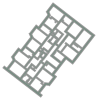

In [11]:
import numpy as np
from shapely.ops import unary_union

# Get tightest boundary of floor plan
# First: load all geometries that are walls or columns
# Second: Unite all these geometries using the union of them
# Third: Find the polygon within the union that is largest in terms of area (using np.argsort)
# and choose the largest (which is by default put on the end of the sort)
geoms, cats, zonings = get_geometries_from_id(DF, building_id, floor_id)

structure = unary_union([geom for geom, cat in zip(geoms, cats) if cat == 'Structure'])
boundary = structure.geoms[np.argsort([geom.area for geom in structure.geoms])[-1]]

# Check whether the boundary / polygon makes sense
# (When a shapely Polygon object is called, the shape is directly visualized in the output.)
boundary

Building ID is  :			15966 
Floor ID is    :			9706 
Number of floors:	5372
Number of apartments:			5
Number of spaces:	14
Number of ciculation spaces (staris, elevators etc):	0
Number of Shafts:	0
Number of structural elements:	40
Number of doors:				7
Number of entrances:			1
Number of windows:			1
Number of zones:				7
Building ID is  :			15966 
Floor ID is    :			9706 
Number of floors:	5372
Number of apartments:			5
Number of spaces:	14
Number of ciculation spaces (staris, elevators etc):	0
Number of Shafts:	0
Number of structural elements:	37
Number of doors:				8
Number of entrances:			2
Number of windows:			2
Number of zones:				7
Building ID is  :			15966 
Floor ID is    :			9706 
Number of floors:	5372
Number of apartments:			5
Number of spaces:	14
Number of ciculation spaces (staris, elevators etc):	0
Number of Shafts:	0
Number of structural elements:	34
Number of doors:				7
Number of entrances:			2
Number of windows:			4
Number of zones:				7
Building ID is  :			15966 
Floo

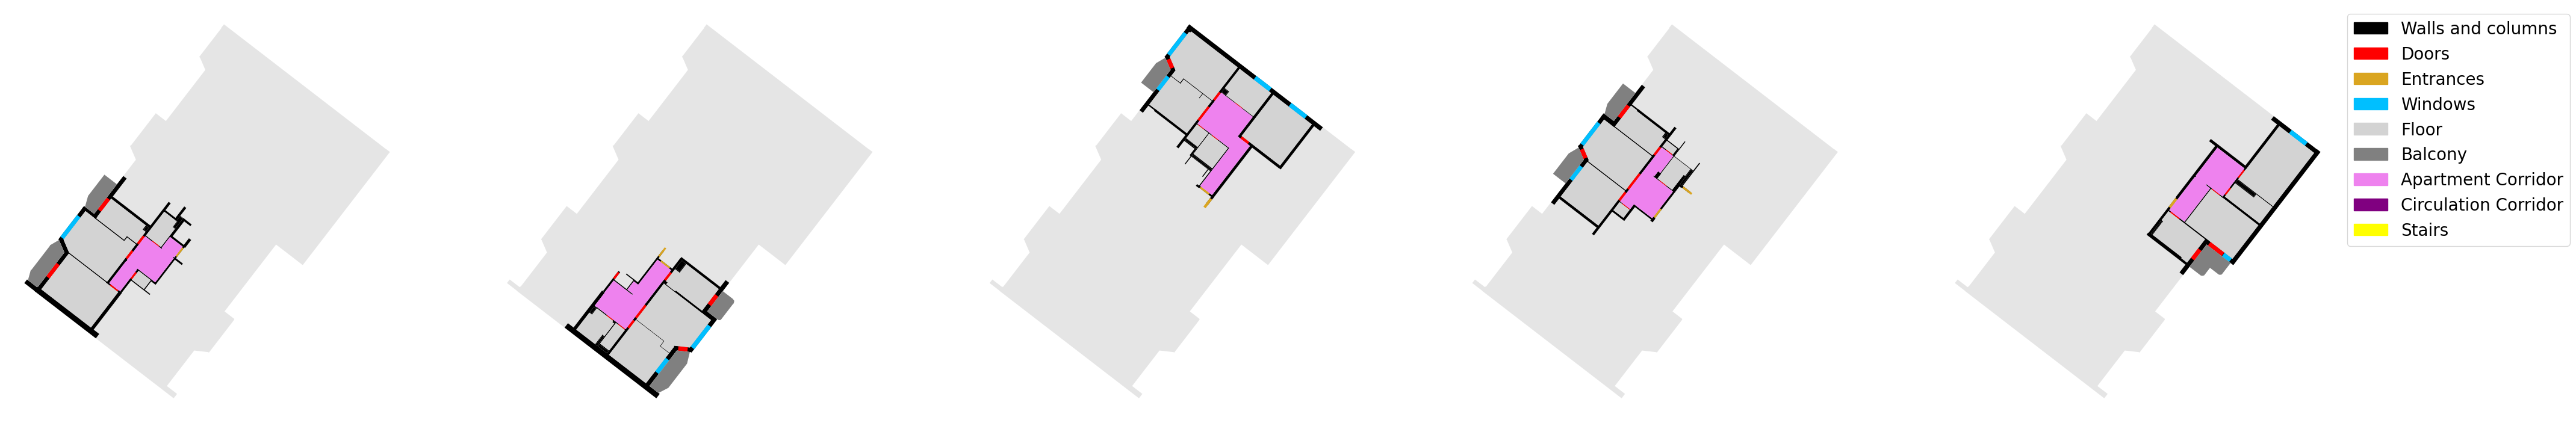

In [13]:
# Set figure and specs
fs = 10
nc = len(apartments)  # Number of columns
fig, axs = plt.subplots(1, nc, figsize=(fs*nc, fs))
axs = axs.flatten()

# Loop through apartments
for ax, (geoms, cats,zonings) in zip(axs, apartments):

    # Set axis
    ax.set_aspect('equal')
    ax.axis('off')

    # Plot structure of the whole building
    plot_polygon(ax, boundary, facecolor="gray", alpha=0.2)

    # Plot geometries
    draw_walls_and_openings(ax, geoms, cats, zonings, apartment_ids,colors)

# Create legend (left middle outside)
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, sep_names)]
_ = plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1, 1), fontsize=fs*2)

You can clearly see that the floor plan is cut into the individual apartments out of which it is composed.

In the next couple of code blocks we will show the spaces as well.

In [14]:
room_names = ['Bedroom', 'Livingroom', 'Kitchen', 'Dining', 'Corridor', 'Stairs', 'Storeroom', 'Bathroom', 'Balcony']
room_colors = ['#1f77b4',   # bedroom
                         '#e6550d',  # living room
                         '#fd8d3c',   # kitchen
                         '#fdae6b',   # dining
                         '#fdd0a2',   # corridor
                         '#72246c',  # stairs
                         '#5254a3',  # storeroom
                         '#6b6ecf',   # bathroom
                         '#2ca09c']  # balcony

def draw_rooms(ax, geoms, cats, zonings, room_colors, room_names):
    """Draws the rooms of the floor plan layout."""
    # Simultaneously extract geometries and categories
    # And directly plot them int the correct color
    for geom, cat in zip(geoms, cats):
        if cat in room_names:
            plot_polygon(ax, geom, facecolor=room_colors[room_names.index(cat)])

['#000000', '#FF0000', 'goldenrod', 'deepskyblue', 'Lightgrey', 'grey', 'violet', 'purple', 'yellow']
Building ID is  :			15966 
Floor ID is    :			9706 
Number of floors:	5372
Number of apartments:			5
Number of spaces:	14
Number of ciculation spaces (staris, elevators etc):	0
Number of Shafts:	0
Number of structural elements:	40
Number of doors:				7
Number of entrances:			1
Number of windows:			1
Number of zones:				7
Building ID is  :			15966 
Floor ID is    :			9706 
Number of floors:	5372
Number of apartments:			5
Number of spaces:	14
Number of ciculation spaces (staris, elevators etc):	0
Number of Shafts:	0
Number of structural elements:	37
Number of doors:				8
Number of entrances:			2
Number of windows:			2
Number of zones:				7
Building ID is  :			15966 
Floor ID is    :			9706 
Number of floors:	5372
Number of apartments:			5
Number of spaces:	14
Number of ciculation spaces (staris, elevators etc):	0
Number of Shafts:	0
Number of structural elements:	34
Number of doors:				7

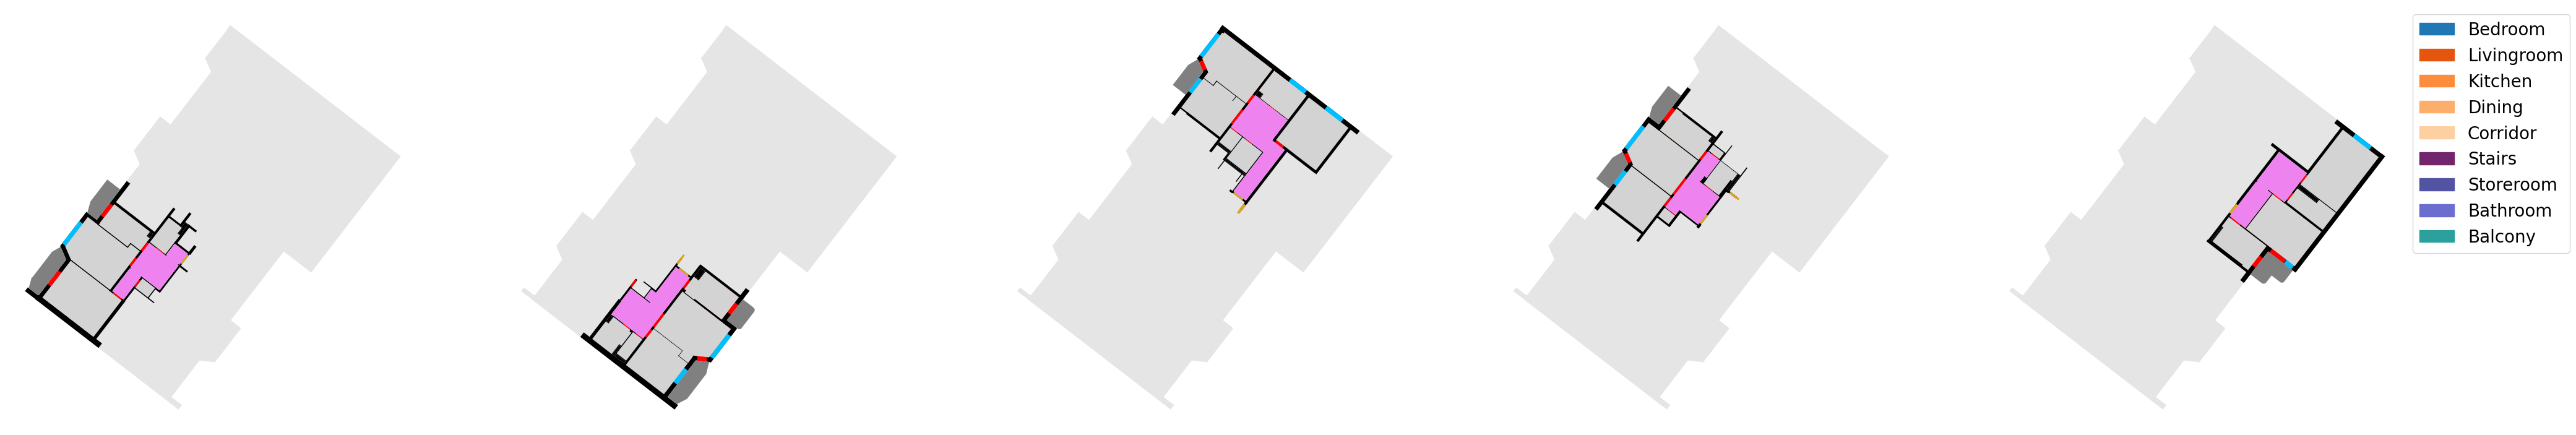

In [15]:
# Set figure and specs
fs = 10
nc = len(apartments)  # Number of columns
fig, axs = plt.subplots(1, nc, figsize=(fs*nc, fs))
axs = axs.flatten()

#Colors and naming for legend
str_colors = colors
legend_colors = room_colors
names = room_names + sep_names
print (str_colors)
# Loop through apartments
for ax, (geoms, cats,zonings) in zip(axs, apartments):

    # Set axis
    ax.set_aspect('equal')
    ax.axis('off')

    # Plot structure of the whole building
    plot_polygon(ax, boundary, facecolor="gray", alpha=0.2)

    # Plot geometries
    draw_rooms(ax, geoms, cats, zonings, room_colors, room_names)
    draw_walls_and_openings(ax, geoms, cats, zonings, apartment_ids,colors)


# Create legend (left middle outside)
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, names)]
_ = plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1, 1), fontsize=fs*2)

### Extracting graphs

Now it is time to extract the graphs.
We do this per individual apartment.
For now, we will not bother about the entrances and the windows, and completely focus on the layout of the apartment as if it would be isolated from the rest of the world.

The graph extraction algorithm below should be self-explainable from the comments.
We include some more features / attributes to the nodes, edges, and the graph itself (1) and the room categorization is slightly modified (2).
The format of the data stays the same; so, if you already worked with the other graph data, it won't be difficult to modify your code to work with the ones we'll extract here.

Graphs are stored as `nx.Graph()` data structures, which IMHO is one of the easiest-to-work-with graph containers you can find in Python.

One thing to highlight here is the WAY to check the connectivity by doors.
The door geometries are temporarily modified by rotating them 90 degrees and making them slightly smaller.

This means that there is more clearly overlap between the rotated door geometry and the two rooms that the door connects.
This makes the algorithm more robust to slightly misplaced doors.


In [ ]:
from warnings import catch_warnings
from types import NotImplementedType
from copy import deepcopy
from itertools import combinations
import torch
import networkx as nx
from shapely.geometry import Polygon
from shapely.affinity import rotate, scale

def rotate_rectangle(rect: Polygon, scale_factor=0.5, angle=90):
    # Compute centroid (center point)
    centroid = rect.centroid

    # Scale the rectangle (relative to the centroid)
    scaled_rect = scale(rect, xfact=scale_factor, yfact=scale_factor, origin=centroid)

    # Rotate the scaled rectangle around its center
    rotated_rect = rotate(scaled_rect, angle, origin=centroid)

    return rotated_rect

def polygon_to_list(polygon: Polygon) -> list:
    """Converts a polygon into a list of coordinates."""
    return list(zip(*polygon.exterior.coords.xy))

def extract_access_graph(geoms, cats, names, apartment_id, floor_id):
    """Extracts the access graph from a set of geometries."""

    # Sets the mapping
    mapping_names = {cat: i for i, cat in enumerate(names)}

    # Initializes empty lists for rooms and their categories, doors, and walls
    rooms, room_cats, doors, entrances, walls, windows = [], [], [], [], [], []

    # Loops through the geometries and corresponding categories
    for geom, cat in zip(geoms, cats):
        if cat ==  'Door':  # Doors
            doors.append(geom)
        elif cat ==  'Entrance Door':  # Entrances
            doors.append(geom)
            entrances.append(geom)
        elif cat in names[:9]:  # Rooms
            rooms.append(geom)
            room_cats.append(cat)
        elif cat == 'Structure':  # Walls and columns
            walls.append(geom)
        elif cat == 'Window': # Windows
            windows.append(geom)
        else: continue

    # Accumulation of NODES (i.e., the rooms)
    nodes = {}
    for key, (room, cat) in enumerate(zip(rooms, room_cats)):

        # Set node and its attributes
        nodes[key] = {
            'polygon': polygon_to_list(room),
            'category': mapping_names[cat],
            'centroid': torch.tensor(np.array([room.centroid.x, room.centroid.y]))
        }

    # Accumulation of EDGES (i.e., room to room connectivity)
    #TODO DOUBLECHECK THER LOGIC HOW ROOMS CONNECT
    edges = []
    for (i, v1), (j, v2) in combinations(enumerate(rooms), 2):

        # (Option 1) Passage (i.e., direct access := no wall in between)
        if v1.distance(v2) < 0.04:
            edges.append([i, j, {'polygon': None, 'connectivity': 'passage'}])

        # (Option 2) Door (i.e., door in between two rooms)
        else:
            edge = False
            for door in doors + entrances:
                door_rotated = rotate_rectangle(door, scale_factor=1)
                if door_rotated.intersection(v1) and door_rotated.intersection(v2):
                    # Adds the geometry of the door as well (slightly different from paper)
                    edge = True
                    edges.append([i, j, {'polygon': polygon_to_list(door), 'connectivity': 'door'}])
                else: continue

            # (Option 2B) By window (i.e., window between balcony and other room)
            # Sometimes, balconies seem disconnected from the apartment (fully).
            # This is likely not the case. So, if a balcony connects with one of the other rooms
            # through a window it is fine as well.
            if not edge and (room_cats[i] == "Balcony" or room_cats[j] == "Balcony"):
                # Check connection based on window overlap
                for window in windows:
                    window_rotated = rotate_rectangle(window)
                    if window_rotated.intersection(v1) and window_rotated.intersection(v2):
                        edges.append([i, j, {'polygon': polygon_to_list(window), 'connectivity': 'door'}])
                    else: continue

    # Get tightest boundary of the apartment
    # (1) Unite all these wall geometries
    # (2) Find the polygon within the union that is largest in terms of area (using np.argsort)
    #   and choose the largest (which is by default put on the end of the sort)
    structure = unary_union(walls)  # (1)
    if structure.geom_type == "MultiPolygon":
        boundary = structure.geoms[np.argsort([geom.area for geom in structure.geoms])[-1]]  # (2)
    elif structure.geom_type == "Polygon":
        boundary = deepcopy(structure)
    else:
        raise NotImplementedType(f"Not implemented for {structure.geom_type}.")

    # Defines the graph
    G = nx.Graph()
    # Graph attributes / features
    G.graph["Floor ID"] = floor_id  # Floor ID
    G.graph["Apt ID"] = apartment_id  # Apartment ID (i.e., name)
    G.graph["Structure"] = walls  # Walls and columns
    G.graph["Windows"] = windows  # Windows
    G.graph["Entrances"] = entrances  # Entrances (doors)
    # Node attributes / features
    G.add_nodes_from([(u, v) for u, v in nodes.items()])
    # Edge attributes / features
    G.add_edges_from(edges)

    return G

Let's load the graphs in a list called `graphs`:

In [ ]:
from IPython.display import clear_output

# Initialize emtpy list for graphs
graphs = []

# Loop over apartments
for i, ((geoms, cats), apartment_id) in enumerate(zip(apartments, apartment_ids)):
    clear_output(wait=True)
    print(f"Graphs extracted: {i+1} / {len(apartments)}")
    G = extract_access_graph(geoms, cats, room_names, apartment_id, floor_id)
    graphs.append(G)

print(graphs[0])

NameError: name 'apartments' is not defined

Next, let's visualize the layouts including their connections from the graphs directly:

In [ ]:
from matplotlib.pyplot import get_cmap
import matplotlib.colors as mcolors

# Set color map
cmap = get_cmap(mcolors.ListedColormap(room_colors))

def draw_floor_from_graph(G, ax, lw=0, s=20, w=2,
                          node_color="white",
                          edge_color="white",
                          viz_rooms=True,
                          viz_walls=True,
                          viz_doors=True,
                          viz_windows=True,
                          viz_entrances=True):

    # Extract information
    rooms = [Polygon(d) for _, d in G.nodes('polygon')]
    cats_idxs = [d for _, d in G.nodes('category')]
    cats = [room_names[i] for i in cats_idxs]
    colors = [np.array(cmap(c_idx)).reshape(1,4) for c_idx in cats_idxs]
    # Instead of the centroid (which could fall for some shapes outside of the perimeter
    # of the shape itself), use a point within the shape. `representation_point()` in shapely
    # does exactly what we need.
    # representative_points = [Polygon(d).representative_point() for n, d in G.nodes('polygon')]
    pos = {n: np.array(
        [Polygon(d).representative_point().x,
         Polygon(d).representative_point().y])
           for n, d in G.nodes('polygon')}

    # Plot rooms
    if viz_rooms:
        draw_rooms(ax, rooms, cats, room_colors, room_names)

    if viz_walls:
        walls = G.graph["Structure"]
        draw_walls_and_openings(ax, walls, ["Structure"]*len(walls), sep_colors)

    if viz_doors:
        doors = [Polygon(d["polygon"]) for _, _, d in G.edges(data=True)]
        draw_walls_and_openings(ax, doors, ["Door"]*len(doors), sep_colors)

    if viz_windows:
        windows = G.graph["Windows"]
        draw_walls_and_openings(ax, windows, ["Window"]*len(windows), sep_colors)

    if viz_entrances:
        entrances = G.graph["Entrances"]
        draw_walls_and_openings(ax, entrances, ["Entrance Door"]*len(entrances), sep_colors)

    # Draw nodes (i.e., rooms)
    if isinstance(s, list):
        nx.draw_networkx_nodes(G, pos, node_size=s, node_color=node_color, ax=ax)
    else:
        nx.draw_networkx_nodes(G, pos, node_size=fs*s, node_color=node_color, ax=ax)

    # Draw edges (i.e., by doors or passages)
    edges = [(u, v) for (u, v) in G.edges()]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_color,
                           width=w, ax=ax)

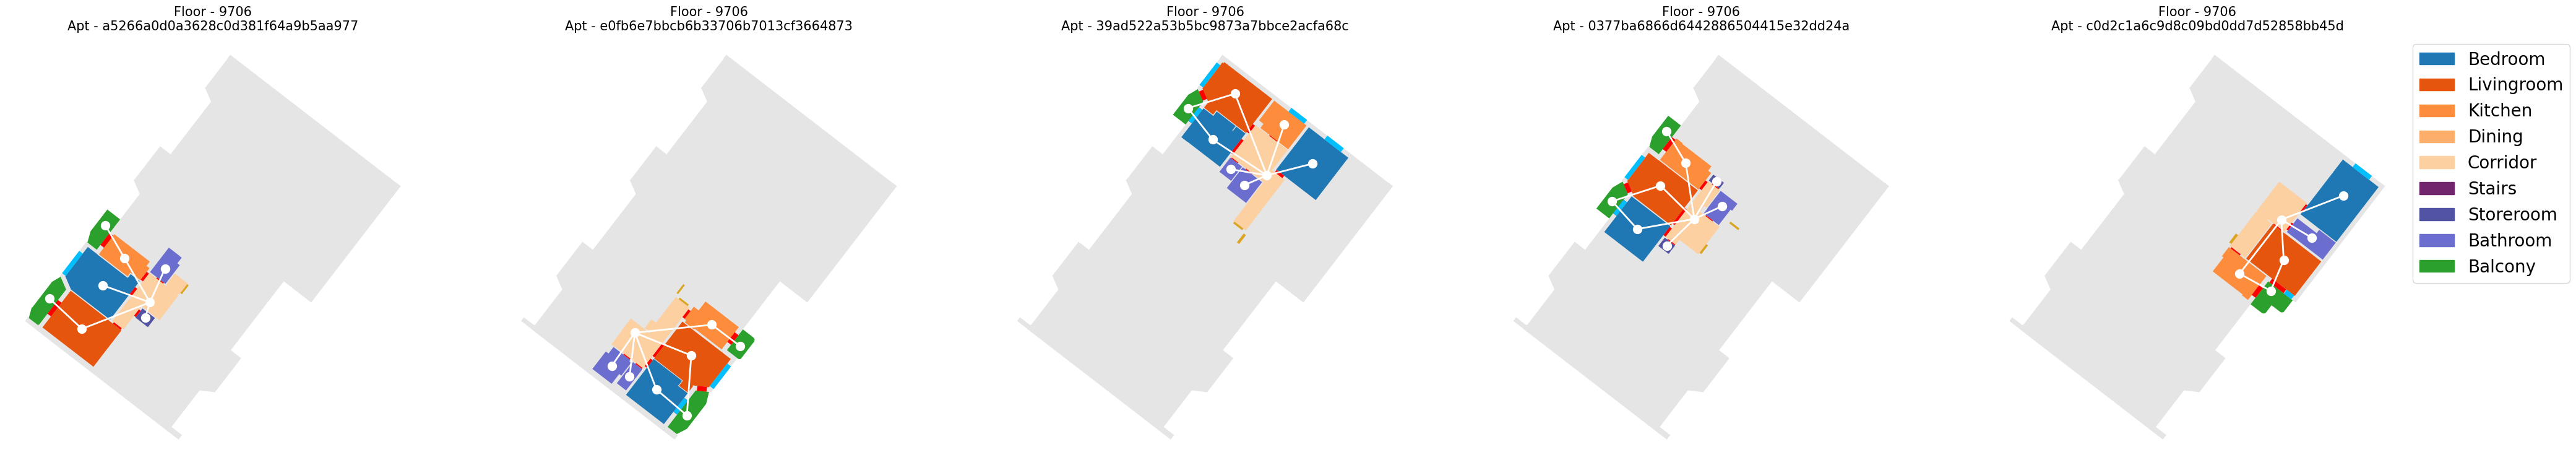

In [ ]:
# Set figure and specs
fs = 10
nc = len(apartments)  # Number of columns
fig, axs = plt.subplots(1, nc, figsize=(fs*nc, fs))
axs = axs.flatten()

# Loop through apartments
for ax, G in zip(axs, graphs):

    # Set axis
    ax.set_aspect('equal')
    ax.axis('off')

    # Plot structure of the whole building
    plot_polygon(ax, boundary, facecolor="gray", alpha=0.2)

    # Plot floor plan + graph on top of it
    draw_floor_from_graph(G, ax, s=fs, w=fs/5,
                          node_color="white",
                          edge_color="white",
                          viz_walls=False)  # Structure not shown. (Remove or set to True if you want to see.)

    # Put title (floor and apt ID)
    ax.set_title(f"Floor - {G.graph['Floor ID']}\nApt - {G.graph['Apt ID']}", fontsize=fs*1.5)

# Create legend (left middle outside)
#patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, names)]
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(room_colors, room_names)]
_ = plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1, 1), fontsize=fs*2)

Now, we can loop over all floor and extract the apartment graphs from them.

In [ ]:
# Compute number of apartments
N_apartments = 0
for floor_id in floor_ids:
    N_apartments += DF[DF.floor_id == floor_id].apartment_id.dropna().nunique()

print(f"Number of apartments:\t{N_apartments}")

Number of apartments:	18889


It takes quite a while to extract all the graphs.
You can also do it for the first 50 floor plans to check the code, like we do in the following block:

In [ ]:
graphs = []

for floor_id in floor_ids[:30]:

    # Get apartment IDs within the floor
    apartment_ids = list(DF[DF.floor_id == floor_id].apartment_id.dropna().unique())

    # Loop over the apartments and extract the graphs
    for apartment_id in apartment_ids:
        geoms, cats = get_geometries_from_id(DF, floor_id, apartment_id=apartment_id)
        G = extract_access_graph(geoms, cats, room_names, apartment_id, floor_id)
        graphs.append(G)

    clear_output(wait=True)
    print(f"Apartments done: {len(graphs)} / {N_apartments}")

Apartments done: 91 / 18889


In [ ]:
import pickle

def save_pickle(object, filename):
    """Saves a pickled file."""
    with open(filename, 'wb') as f:
        pickle.dump(object, f)
    f.close()

# Saves graphs
save_pickle(graphs, '/content/drive/MyDrive/MSD_V2/MSD_export/MSD - Some Apartment-Level Graphs.pickle')

Again, we can visualize them (say 20 by 6).

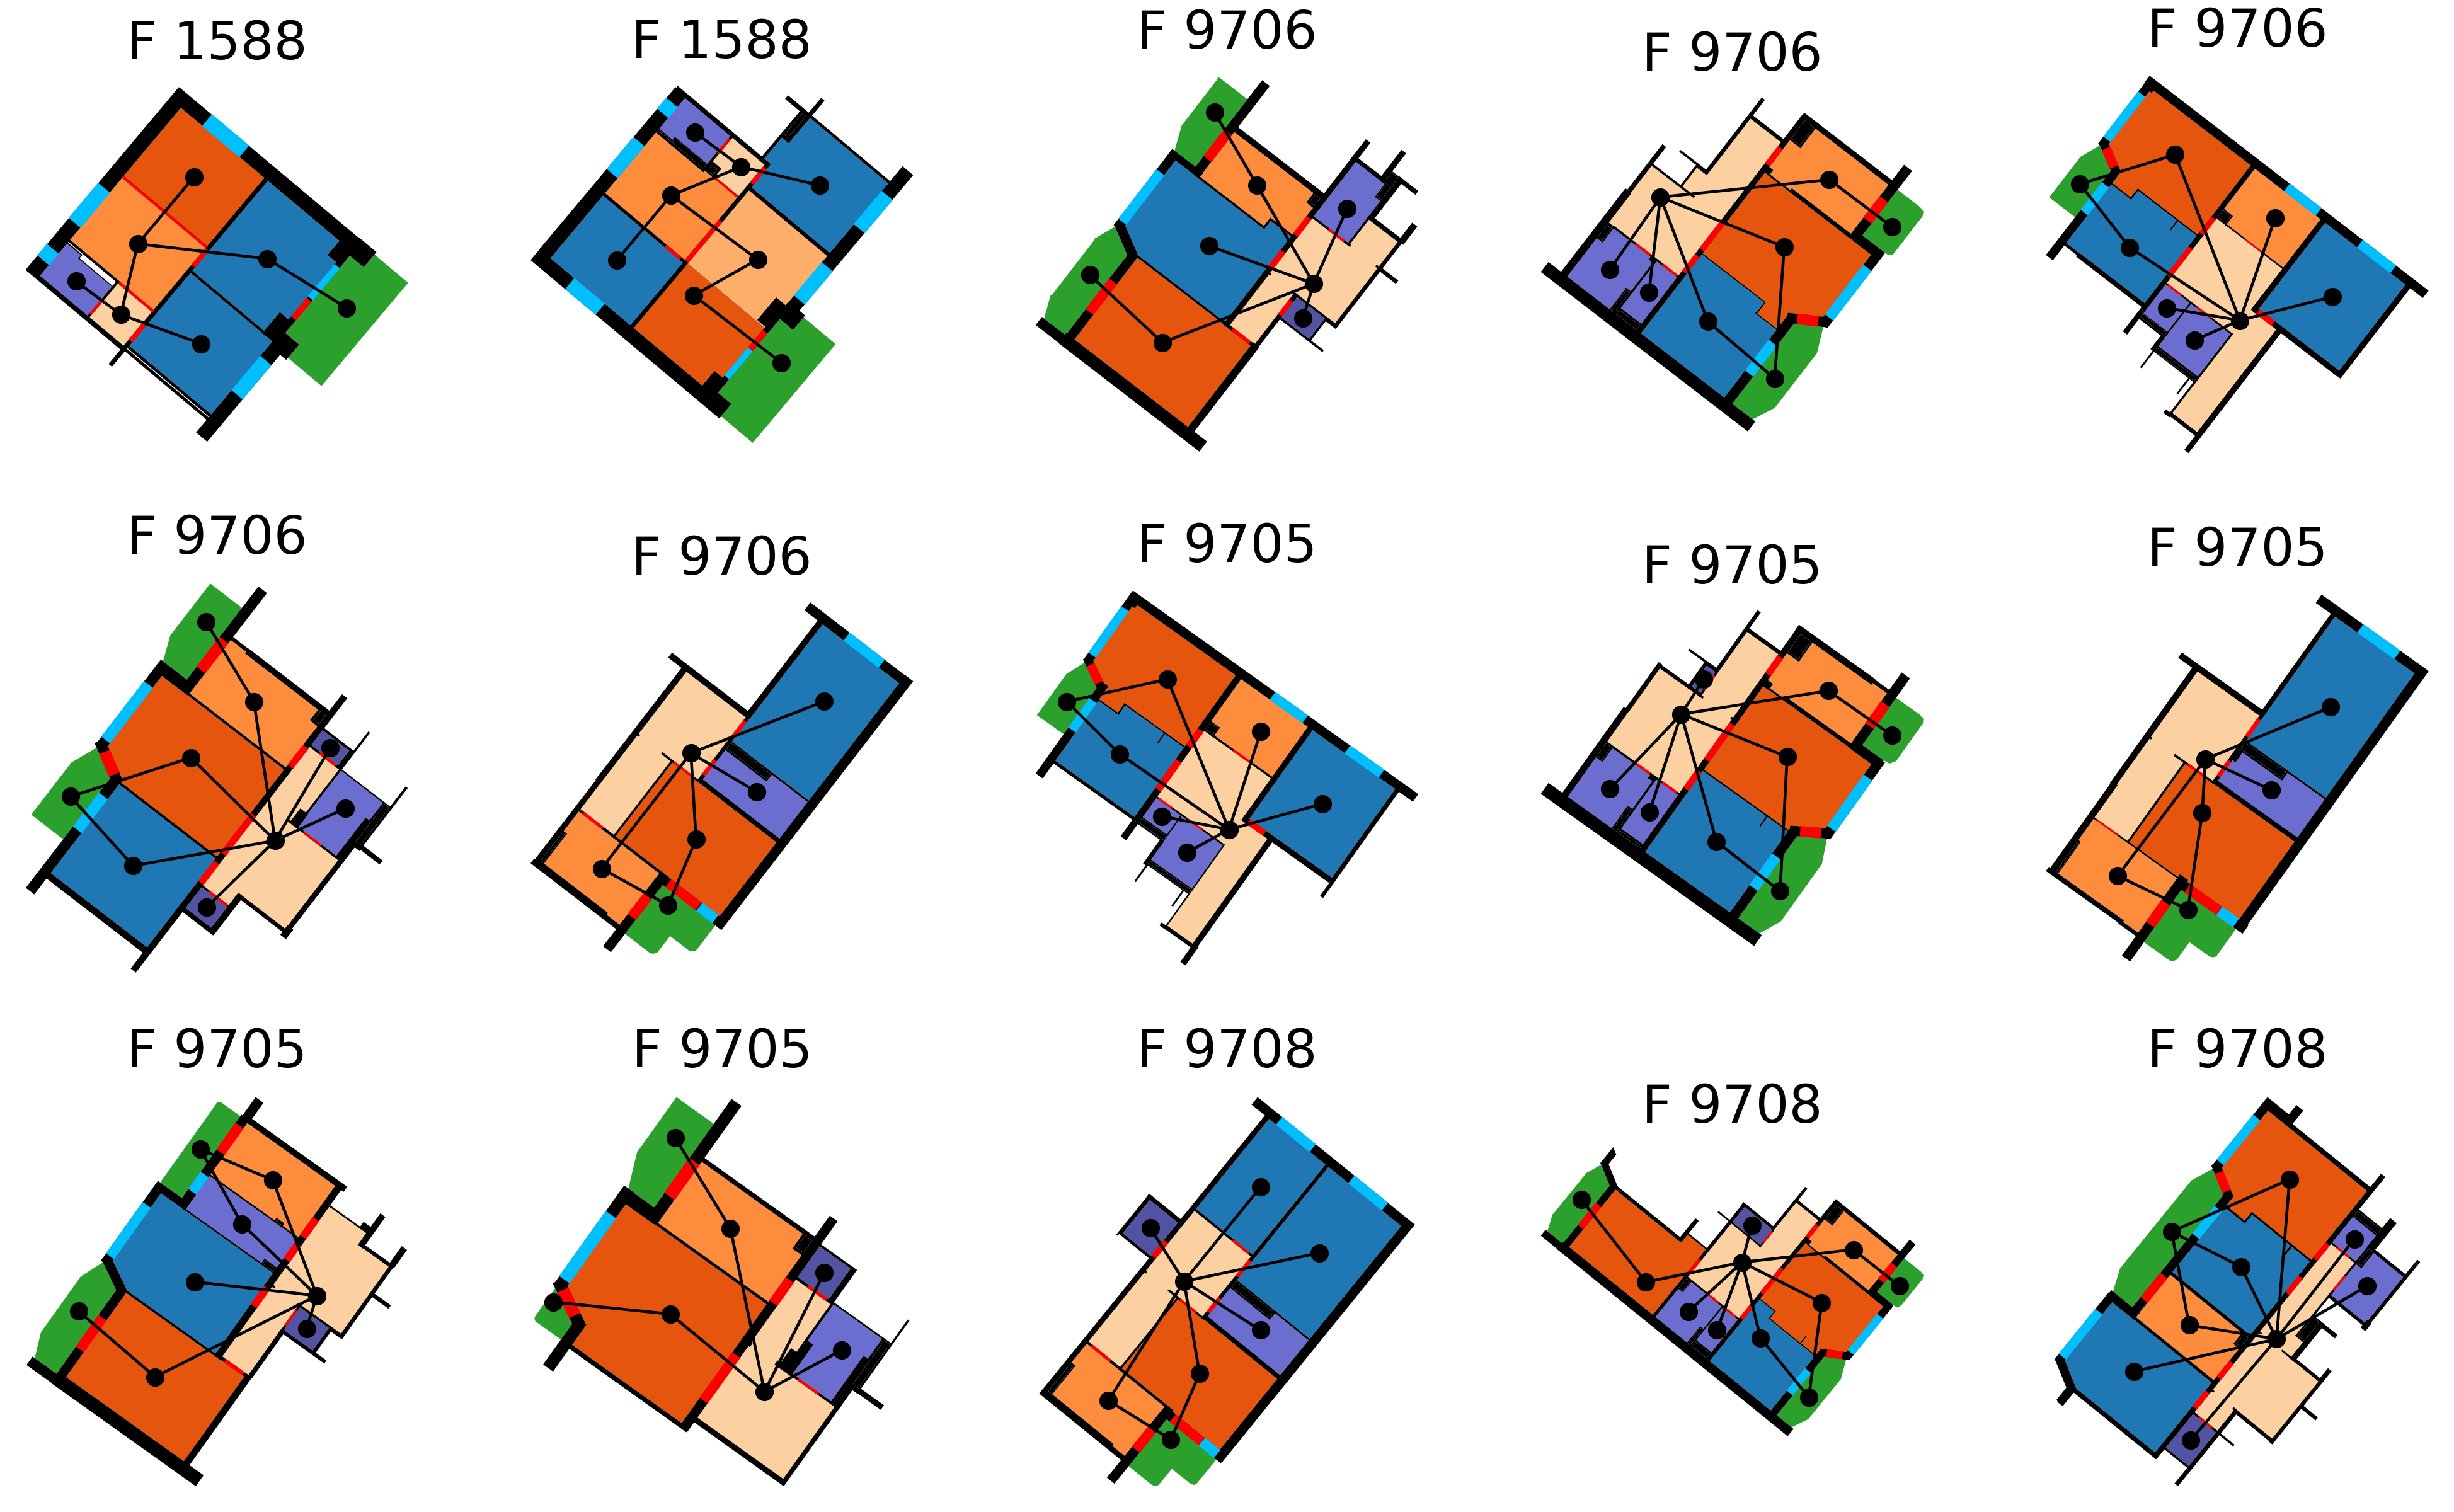

In [ ]:
# Set figure and specs
fs = 10
nc, nr = 5, 3
fig, axs = plt.subplots(nr, nc, figsize=(fs*nc, fs*nr))
axs = axs.flatten()

# Set coloring of graph
node_color = edge_color = "grey"

# Loop through apartments
for ax, G in zip(axs, graphs[:len(axs)]):

    # Set axis
    ax.set_aspect('equal')
    ax.axis('off')
    #Put title (floor and apt ID)
    ax.set_title(f"F {G.graph['Floor ID']}", fontsize=fs*6)

    # Plot floor plan + graph
    draw_floor_from_graph(G, ax, s=fs*4, w=fs/3,
                          node_color=node_color,
                          edge_color=edge_color,
                          viz_walls=True,
                          viz_entrances=False)



## (2) Filtering

This section is about removing apartment layouts that are either nearly similar to others (1) are not very informative (e.g., the upper part of an apartment that might only have 1 bedroom) (2).
Why (1)? Too many very similar layouts will slow down and likely bias training.
Why (2)? Good question ...

### Counting storeys in an apartment

Some apartments live at multiple storeys in a building.

Let's plot the histogram of the number of storeys apartments have.
This is easily extracted from the dataframe by counting the number of unique floor IDs can be found when the dataframe is filtered on a particular apartment ID.

In [ ]:
# Get apartment IDs
apartment_ids = list(DF.apartment_id.dropna().unique())
print(len(apartment_ids))

# Get unit IDs (Should be more!)
unit_ids = list(DF.unit_id.dropna().unique())
print(len(unit_ids))

In [ ]:
# Get storeys per apartment dataframe
storeys_per_apartment = DF.groupby('apartment_id')['floor_id'].nunique()

In [ ]:
# Set figure
fs = 7
fig, ax = plt.subplots(1, 1, figsize=(fs, fs))

# Histogram
ax.hist(storeys_per_apartment, bins=range(1, storeys_per_apartment.max() + 2), color='black', align='left', log=True, rwidth=0.9)

# Set labels
ax.set_xlabel('Number of Storeys', fontsize=fs*2)
ax.set_ylabel('Number of Apartments', fontsize=fs*2)
_ = ax.set_title('Storeys per Apartment', fontsize=fs*3)

# Set axes
ax.grid(axis='y', linestyle='--', alpha=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Since there are only a few apartments covering multiple storeys, we simply don't consider these apartments.

In [ ]:
single_apartment_ids = storeys_per_apartment[storeys_per_apartment == 1].index.tolist()
print("Apartments that only occupy one floor level: ", len(single_apartment_ids))

### Extracting all apartment graphs that are single storey

In the next cell, we will convert all the (single-storey) apartments to information-rich graphs and put them together in a list.
This procedure takes quite some time (~30 min, depending on your machine / server).
Make sure to save it afterwards: Loading the list of graphs from your folder takes way less time than repeating the extraction.

In [ ]:
graphs = []

for floor_id in floor_ids:

    # Get apartment IDs within the floor
    apartment_ids = list(DF[DF.floor_id == floor_id].apartment_id.dropna().unique())
     # Remove those that are covering more than 1 storey (by set intersection)
    apartment_ids = list(set(apartment_ids).intersection(set(single_apartment_ids)))

    # Loop over the apartments and extract the graphs
    for apartment_id in apartment_ids:
        geoms, cats = get_geometries_from_id(DF, floor_id, apartment_id=apartment_id)
        G = extract_access_graph(geoms, cats, names, apartment_id, floor_id)
        graphs.append(G)

    clear_output(wait=True)
    print(f"Apartments done: {len(graphs)} / {len(single_apartment_ids)}")

Again: don't forget to save them.
Note that it's about 150MB only!

In [ ]:
# Saves graphs
save_pickle(graphs, f'/content/drive/My Drive/mds_V2/MSD - Apartment-Level Graphs {len(graphs)/1000:.1f}K.pickle')

Load the graphs

In [ ]:
def load_pickle(filename):
    """
    Loads a pickled file.
    """
    with open(filename, 'rb') as f:
        object = pickle.load(f)
        f.close()
    return object

In [ ]:
graphs = load_pickle('/content/drive/My Drive/mds_V2/MSD_export/MSD - Some Apartment-Level Graphs.pickle')

Let's visualize a couple of them:

In [ ]:
import random

# Set figure and specs
fs = 10
nc, nr = 5, 5
fig, axs = plt.subplots(nr, nc, figsize=(fs*nc, fs*nr))
axs = axs.flatten()

# Set coloring of graph
node_color = edge_color = "black"

# Loop through apartments (pick at random)
random.seed(32)
for ax, G in zip(axs, random.sample(graphs, k=nc*nr)):

    # Set axis
    ax.set_aspect('equal')
    ax.axis('off')

    # Plot floor plan + graph
    draw_floor_from_graph(G, ax, s=fs*4, w=fs/3,
                          node_color=node_color,
                          edge_color=edge_color,
                          viz_walls=False,
                          viz_entrances=False)

    # Put title (floor and apt ID)
    ax.set_title(f"Floor ID: {G.graph['Floor ID']}", fontsize=fs*5)

While many of the floor plans are great, there are many that are not really informative, such as:

- Floor plans that consist of a few number of rooms (some are only bedrooms ...)
- Floor plans without a living room. Reconsidered: We keep them in, there are many apartments without it.

Let's check the sizes (in terms of amount of rooms) of the apartments (1) and number of apartments with a living room more closely (2).

In [ ]:
from tqdm.auto import tqdm

N_rooms = []
N_with_living = 0

for G in tqdm(graphs):
    N_rooms.append(G.number_of_nodes())  # (1)
    # Checks presence of living room among the nodes
    N_with_living += 1 if 1 not in [d for _, d in G.nodes(data="category")] else 0  # (2)

In [ ]:
# Print number of apartments that have a living room
print(N_with_living)
print(N_rooms[:50])

Check distribution of the apartment sizes (i.e., the amount of rooms) through a histogram.

In [ ]:
# Set figure
fs = 7
fig, ax = plt.subplots(1, 1, figsize=(fs, fs))

# Histogram
ax.hist(N_rooms, bins=range(1, np.max(N_rooms) + 2), color='black', align='left', rwidth=0.7)

# Set labels
ax.set_xlabel('Number of Spaces', fontsize=fs*2)
ax.set_ylabel('Number of Apartments', fontsize=fs*2)
_ = ax.set_title('Number of Spaces per Apartment', fontsize=fs*3)

# Set axes
ax.grid(axis='y', linestyle='--', alpha=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

We keep all apartments that have between 5 and 7 rooms.

In [ ]:
graphs_subset = [G for G in tqdm(graphs) if 5 <= G.number_of_nodes() <= 7]

print(f"Number of apartments with 5-12 rooms: {len(graphs_subset)}")

Some apartment are not fully connected.
Here, we keep all apartments that are connected.

In [ ]:
graphs_subset = [G for G in tqdm(graphs_subset) if nx.is_connected(G)]

print(f"Number of apartments with 5-12 rooms and connected: {len(graphs_subset)}")

So, ultimately, in the final dataset we have 16771 apartment-level floor plan graphs.

In [ ]:
import random

# Set figure and specs
fs = 10
#number of rows and columns in the figure
nc, nr = 10, 10
fig, axs = plt.subplots(nr, nc, figsize=(fs*nc, fs*nr))
axs = axs.flatten()

# Set coloring of graph
viz_rooms = True
viz_walls = False
viz_entrances = False
viz_doors = True
viz_windows = True
node_color = edge_color ="black" # other option: fuchsia (pink!)

# Loop through apartments (pick at random)
random.seed(30)
for ax, G in zip(axs, random.sample(graphs_subset, k=nc*nr)):

    # Set axis
    ax.set_aspect('equal')
    ax.axis('off')

    # Plot floor plan + graph
    draw_floor_from_graph(G, ax, s=fs*4, w=fs/3,
                          node_color=node_color,
                          edge_color=edge_color,
                          viz_rooms=viz_rooms,
                          viz_walls=viz_walls,
                          viz_entrances=viz_entrances,
                          viz_doors = viz_doors,
                          viz_windows = viz_windows)

    # Put title (floor and apt ID)
    # ax.set_title(f"F {G.graph['Floor ID']}", fontsize=fs*6)

Let's save this 'cleaned' dataset as well:

In [ ]:
save_pickle(graphs_subset, f'/content/drive/MyDrive/MSD_V2/MSD_export/MSD - Apartment-Level Graphs Cleaned {len(graphs_subset)/1000:.1f}K.pickle')

## (3) Meta-data analysis

This part of the notebook sheds light on the meta-data of the dataset.

We divide it into three categories:

- Numeric
- Semantic
- Geometric
- Topological

### Numeric

First things first.
The next shows the apartment size distribution (as per number of rooms).
We already did this before, but not for the final dataset!

In [ ]:
N_rooms = [G.number_of_nodes() for G in graphs_subset]

N_rooms_dict = {n: N_rooms.count(n) for n in np.sort(list(set(N_rooms)))}

NameError: name 'graphs_subset' is not defined

In [ ]:
# Get naming and occurrences for the bars
names = N_rooms_dict.keys()
occurrences = N_rooms_dict.values()

# Set figure
fs = 7
tc = "black"
fig, ax = plt.subplots(1, 1, figsize=(fs, fs))

# Histogram
bars = ax.bar(names, occurrences, color='black')

# Set labels
ax.set_xlabel('Number of rooms', fontsize=fs*3)
ax.set_ylabel('Amount of apartments', fontsize=fs*3)
ax.tick_params(axis='both', width=fs/3, labelsize=fs*2)

# Set axes / spines
ax.spines['bottom'].set_color(tc)
ax.spines['left'].set_color(tc)
ax.spines['bottom'].set_linewidth(fs/3)
ax.spines['left'].set_linewidth(fs/3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Hide the y-axis ticks and labels
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])

# Add scores on top of the bars
for bar, occurrence in zip(bars, occurrences):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{occurrence}', ha='center', va='bottom', fontsize=2.5*fs)

### Semantic

We will extract the **room type distribution** i.e., the total number of rooms per room type across the whole dataset.

In [ ]:
# Set classes (int) based on the room names list
classes = list(range(len(room_names)))

# The following creates a list of categories by looping over all the rooms across all graphs
N_room_types = np.concatenate([np.array([cat for _, cat in G.nodes(data="category")]) for G in graphs_subset]).tolist()

# This creates a dictionary: keys are the room types and the values are the number occurrences
# of that room type in the dataset
N_room_type_dict = {room_names[cat]: N_room_types.count(cat) for cat in classes}

# We sort the dictionary by the count of the rooms
N_room_type_dict = dict(sorted(N_room_type_dict.items(), key=lambda item: item[1], reverse=True))

In [ ]:
# Get naming and occurrences for the bars
names = N_room_type_dict.keys()
occurrences = N_room_type_dict.values()

# Set figure
fs = 7
tc = "black"
fig, ax = plt.subplots(1, 1, figsize=(fs*2, fs))

# Histogram
color = [room_colors[room_names.index(cat)] for cat in names]
bars = ax.bar(names, occurrences, color=color)

# Set labels
ax.set_ylabel('Amount', fontsize=fs*3)
ax.tick_params(axis='both', width=fs/3, labelsize=fs*2)

# Set axes / spines
ax.spines['bottom'].set_color(tc)
ax.spines['left'].set_color(tc)
ax.spines['bottom'].set_linewidth(fs/3)
ax.spines['left'].set_linewidth(fs/3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Hide the y-axis ticks and labels
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
_ = plt.xticks(rotation=60)

# Add scores on top of the bars
for bar, occurrence in zip(bars, occurrences):
    p = 100 * occurrence / sum(occurrences)  # Computes percentage
    height = bar.get_height()  # Sets the height of the bar in the plot
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{occurrence}', ha='center', va='bottom', fontsize=2.5*fs)

### Geometric

We will extract the distributions of the following:
- Gross area (in $m^2$)
- Area per room type (in $m^2$)
- Area of a room type w.r.t. gross area (in %)

The **gross area**, or total area of a floor plan is measured in $m^2$, and computed as the sum over all room areas.

In [ ]:
# Aggregate gross areas in a list
gross_areas = [np.sum([Polygon(d).area for _, d in G.nodes('polygon')]) for G in graphs_subset]

In [ ]:
# Set figure
fs = 7
fc = "white"
tc = "black"
fig, ax = plt.subplots(1,1,figsize=(fs*2, fs))

# Create histogram
bars = ax.hist(gross_areas, bins=75, color="black", align='left', rwidth=1)

# Set color
fig.set_facecolor(fc)
ax.set_facecolor(fc)

# Make up spines
ax.spines['bottom'].set_color(tc)
ax.spines['left'].set_color(tc)
ax.spines['bottom'].set_linewidth(fs/5)
ax.spines['left'].set_linewidth(fs/5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make up ticks
ax.tick_params(axis='both', width=fs/5, labelsize=fs*2)

# Set grid
ax.grid(axis='y', linestyle='--', alpha=1)

# Make up labels
_ = ax.set_ylabel("Number of floor plans", fontsize=fs*3)
_ = ax.set_xlabel("Gross area [m2]", fontsize=fs*3)

We will do the same, but for each room type individually.
So, we'll get the **distribution of area per room type** (on average across the whole dataset).

In [ ]:
# Aggregate room areas in a dict (key indicates the room type)
room_areas_dict = {cat: [] for cat in room_names}

# Loop over graphs and nodes
for G in graphs_subset:
    for _, d in G.nodes(data=True):
        # Extract category
        cat = room_names[d["category"]]
        # Append to the right list in the dictionary
        room_areas_dict[cat].append(Polygon(d["polygon"]).area)

First, we create bar plot.
Each bar represents a room type.
We compute the mean and standard deviation of the list of areas (values in the dictionary) for each room type category (keys in the dictionary).

In [ ]:
# Create dictionary with statistics of the distribution (mean and std)
S_room_areas_dict = {cat: [np.mean(areas), np.std(areas)] for cat, areas in room_areas_dict.items()}

# Sort dictionary on mean area size (descending order)
S_room_areas_dict = dict(sorted(S_room_areas_dict.items(), key=lambda item: item[1][0], reverse=True))

In [ ]:
# Get naming and occurrences for the bars
names = S_room_areas_dict.keys()
means = [m for m,_ in S_room_areas_dict.values()]
sigmas = [sig for _, sig in S_room_areas_dict.values()]

# Set figure
fs = 7
tc = "black"
fig, ax = plt.subplots(1, 1, figsize=(fs*2, fs))

# Histogram
colors = [room_colors[room_names.index(cat)] for cat in names]
bars = ax.bar(names, means, color=colors)

# Set labels
ax.set_ylabel('Area [m2] ($\mu \pm \sigma$)', fontsize=fs*3)
ax.tick_params(axis='both', width=fs/3, labelsize=fs*2)

# Set axes / spines
ax.spines['bottom'].set_color(tc)
ax.spines['left'].set_color(tc)
ax.spines['bottom'].set_linewidth(fs/3)
ax.spines['left'].set_linewidth(fs/3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Hide the y-axis ticks and labels
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
_ = plt.xticks(rotation=60)

# Add scores on top of the bars
for bar, mean, sig in zip(bars, means, sigmas):
    height = bar.get_height()  # Sets the height of the bar in the plot
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{mean:.1f}$\pm${sig:.1f}', ha='center', va='bottom', fontsize=2.5*fs)

To investigate more of the details of the individual area distributions, we can similarly visualize the distributions of each of them (using histograms like for the gross area).
We color the the histograms accordingly.

In [ ]:
# Set up figure
fs = 10
fc = "white"
tc = "black"
fig, axs = plt.subplots(2, 5, figsize=(fs*5, fs*2))
axs = axs.flatten()

for ax, cat, color in zip(axs, names, colors):

    # Create histogram
    bars = ax.hist(room_areas_dict[cat], bins=50, color=color)

    # Global coloring
    fig.set_facecolor(fc)
    ax.set_facecolor(fc)

    # Make up spines
    ax.spines['bottom'].set_color(tc)
    ax.spines['left'].set_color(tc)
    ax.spines['bottom'].set_linewidth(fs/3)
    ax.spines['left'].set_linewidth(fs/3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_visible(False)

    # Set lim
    # ax.set_xlim([0, 65])

    # Set grid
    ax.grid(axis='y', linestyle='--', alpha=1)

    # Make up ticks
    _ = plt.xticks(rotation=60)
    ax.tick_params(axis='both', width=fs/3, labelsize=fs*4)

    # Set title
    ax.set_title(cat, fontsize=fs*5)

for i in [-1]:
    axs[i].axis("off")

### Topological

Here, we compute the mean (and standard deviation) number connections per room type.

In [ ]:
# Aggregate connections (i.e., degree) areas in a dict (key indicates the room type)
room_degree_dict = {cat: [] for cat in room_names}

# Loop over graphs and nodes
for G in graphs_subset:
    for n, d in G.nodes(data=True):
        # Extract category
        cat = room_names[d["category"]]
        # Append to the correct list in the dictionary
        room_degree_dict[cat].append(G.degree(n))

In [ ]:
# Create dictionary with statistics of the distribution (mean and std)
S_room_degree_dict = {cat: [np.mean(areas), np.std(areas)] for cat, areas in room_degree_dict.items()}

# Sort dictionary on mean area size (descending order)
S_room_degree_dict = dict(sorted(S_room_degree_dict.items(), key=lambda item: item[1][0], reverse=True))

In [ ]:
# Get naming and occurrences for the bars
names = S_room_degree_dict.keys()
means = [m for m,_ in S_room_degree_dict.values()]
sigmas = [sig for _, sig in S_room_degree_dict.values()]

# Set figure
fs = 7
tc = "black"
fig, ax = plt.subplots(1, 1, figsize=(fs*2, fs))

# Histogram
colors = [room_colors[room_names.index(cat)] for cat in names]
bars = ax.bar(names, means, color=colors)

# Set labels
ax.set_ylabel('Degree [-] ($\mu \pm \sigma$)', fontsize=fs*3)
ax.tick_params(axis='both', width=fs/3, labelsize=fs*2)

# Set axes / spines
ax.spines['bottom'].set_color(tc)
ax.spines['left'].set_color(tc)
ax.spines['bottom'].set_linewidth(fs/3)
ax.spines['left'].set_linewidth(fs/3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Hide the y-axis ticks and labels
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
_ = plt.xticks(rotation=60)

# Add scores on top of the bars
for bar, mean, sig in zip(bars, means, sigmas):
    height = bar.get_height()  # Sets the height of the bar in the plot
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{mean:.1f}$\pm${sig:.1f}', ha='center', va='bottom', fontsize=2.5*fs)